In [3]:
#!/user/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 2 16:21:05 2022

@author: lautaro_silbergleit
"""

import numpy as np
from scipy.optimize import curve_fit
import control as ct
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
estacionarios = np.loadtxt('barrido_megafull.txt', delimiter=',', skiprows=1)
step = np.loadtxt('ziegler_nichols_square_escalon_6.txt', delimiter=',', skiprows=1)

max_res = np.mean(step[np.where(step[:,0] > .75),2])
t_step = step[np.argmax(step[:,1] > 1),0]

In [5]:
@np.vectorize
def exp_approach(t, a):
    return (1 - np.exp(-a*t)) * (t > 0)

Text(0.5, 1.0, 'first approximation')

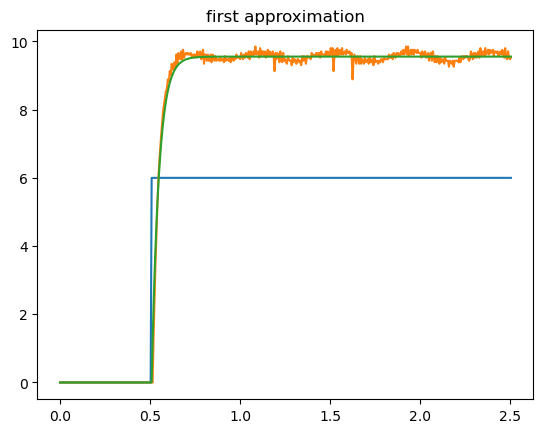

In [6]:
plt.plot(step[:,0], step[:,1])
plt.plot(step[:,0], step[:,2])
plt.plot(step[:,0], max_res * exp_approach(step[:,0] - t_step, 25))
plt.title('first approximation')

In [7]:
popt, pcov = curve_fit(exp_approach, step[:,0] - t_step, step[:,2] / max_res, p0=[25])
perr = np.sqrt(np.diag(pcov))
alpha = popt[0]
popt, perr

(array([25.79440639]), array([0.29764063]))

Text(0.5, 1.0, 'best $\\alpha$')

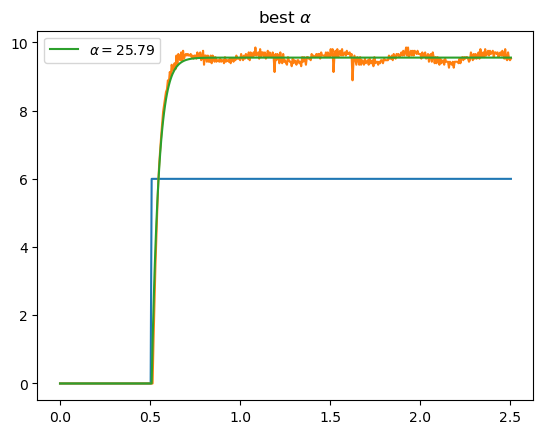

In [8]:
plt.plot(step[:,0], step[:,1])
plt.plot(step[:,0], step[:,2])
plt.plot(step[:,0], max_res * exp_approach(step[:,0] - t_step, alpha), label=f'$\\alpha={round(alpha,2)}$')
plt.legend()
plt.title('best $\\alpha$')

#### Laplace Transform exponential approach

$$e^{-\alpha t}u(t)$$

$$\frac{\alpha}{s^{2}+\alpha s}$$

Pero por alguna razón que desconozco completamente uso

$$\frac{\alpha s}{s^{2}+\alpha s}$$

Se puede sumar termino cte en el denominador para dar cuenta del rozamiento

In [9]:
num = [alpha, 0] # POR QUE NO ES [ALPHA]??? NO ENTIENDO. AMERICA EXPLAIN!!!
den = [1, alpha, 0]
sys = ct.tf(num, den)
print(sys)
sys = ct.ss(sys)


   25.79 s
-------------
s^2 + 25.79 s



#### Ploteo la step response junto con la simulación

Text(0.5, 1.0, 'simulation')

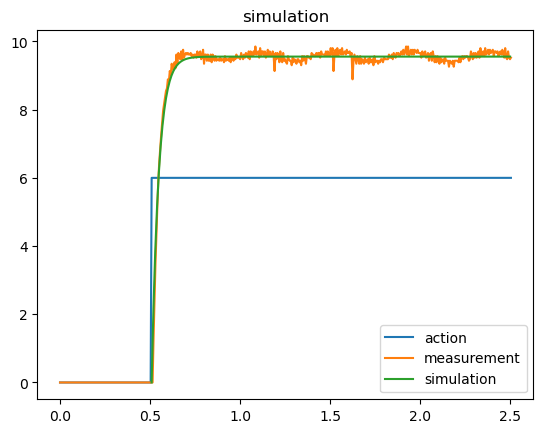

In [10]:
dt = 0.005
t = np.arange(np.min(step[:,0]), np.max(step[:,0]) - t_step, dt)
ts, ys = ct.step_response(sys, t)
ts += t_step
ys *= max_res


plt.plot(step[:,0], step[:,1], label='action')
plt.plot(step[:,0], step[:,2], label='measurement')
plt.plot(ts, ys, label='simulation')
plt.legend()
plt.title('simulation')

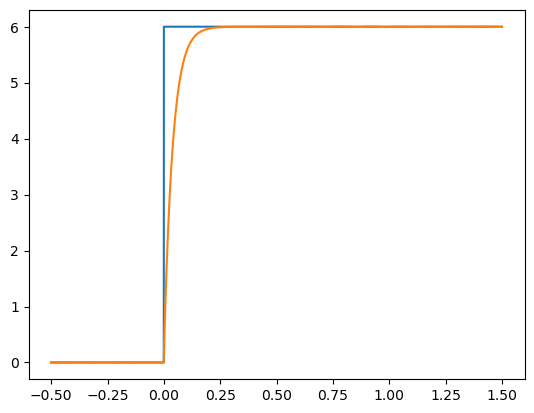

In [11]:
dt = 0.0005
step = 6

ts = np.arange(-0.5, 1.5, dt)
p_ziegler = np.zeros((ts.shape[0], 3))
p_ziegler[:,0] = ts
p_ziegler[:,1] = np.vectorize(lambda e: step if e > 0 else 0)(ts)
_, p_ziegler[:,2] = ct.input_output_response(sys, p_ziegler[:,0], p_ziegler[:,1])

plt.plot(p_ziegler[:,0], p_ziegler[:,1])
plt.plot(p_ziegler[:,0], p_ziegler[:,2])

In [12]:
dy = np.gradient(p_ziegler[:,2])
dx = np.gradient(p_ziegler[:,0])
max_deriv_idx = np.argmax(dy/dx)

tang_m = dy[max_deriv_idx] / dx[max_deriv_idx]
tang_off = p_ziegler[max_deriv_idx,0]
tang_b = p_ziegler[max_deriv_idx,2]
tangent = tang_m * (p_ziegler[:,0] - tang_off) + tang_b

In [27]:
y_min_step = np.mean(p_ziegler[np.where(p_ziegler[:,1] < 0.5),1])
y_max_step = np.mean(p_ziegler[np.where(p_ziegler[:,1] > 0.5),1])
y_min_res = np.mean(p_ziegler[np.where(p_ziegler[:,1] < 0.5),2])
y_max_res = np.mean(p_ziegler[np.where(p_ziegler[:,0] > 1),2])

t_step_idx = np.argmax(np.gradient(p_ziegler[:,1]))
t0 = p_ziegler[t_step_idx, 0]

t1 = p_ziegler[np.argmin(np.abs(tangent - y_min_res)), 0] - t0
t1 = max(t1, 1e-10)
t2 = p_ziegler[np.argmin(np.abs(tangent - y_max_res)), 0] - t1 - t0

dx = y_max_step - y_min_step
dy = y_max_res - y_min_res

In [28]:
# obtengo PID
ko = (dx * t2) / (dy * t1)

def get_PID_params(mode, ko=ko):
    mode = mode.upper()
    if mode == 'P':
        return ko, 0, 0
    elif mode == 'PI':
        return .9 * ko, .27 * ko / t1, 0
    elif mode == 'PD':
        return 1.6 * ko, 0, .6 * ko * t1
    elif mode == 'PID':
        return 1.2 * ko, .6 * ko / t1, .6 * ko * t1
    else:
        raise Exception('Bad mode')

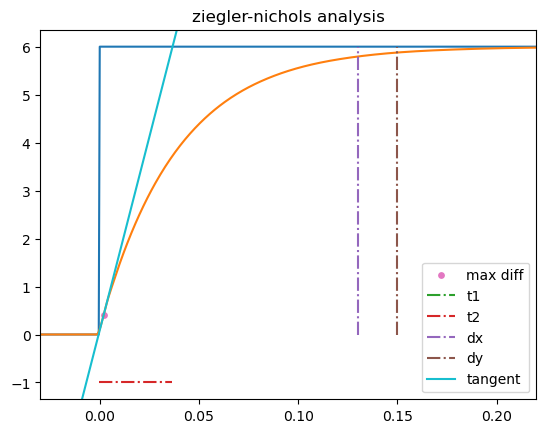

In [29]:
plt.plot(p_ziegler[:,0], p_ziegler[:,1])
plt.plot(p_ziegler[:,0], p_ziegler[:,2], '-')
plt.scatter(p_ziegler[max_deriv_idx,0], p_ziegler[max_deriv_idx,2], s=15, color='tab:pink', label='max diff')
plt.plot([t0, t0 + t1], [-1, -1], label='t1', ls='-.')
plt.plot([t0 + t1, t0 + t1 + t2], [-1, -1], label='t2', ls='-.')
plt.plot([.13, .13], [0, dx], label='dx', ls='-.')
plt.plot([.15, .15], [0, dy], label='dy', ls='-.')
limx = plt.xlim()
limx=(-.03, .22)
limy = plt.ylim()
plt.plot(p_ziegler[:,0], tangent, color='tab:cyan', label='tangent')
plt.xlim(limx)
plt.ylim(limy)
plt.legend()
plt.title('ziegler-nichols analysis')
#plt.savefig('step.png', dpi=150)
plt.show()

#### Ploteo los estacionarios

FloatingPointError: underflow encountered in nextafter

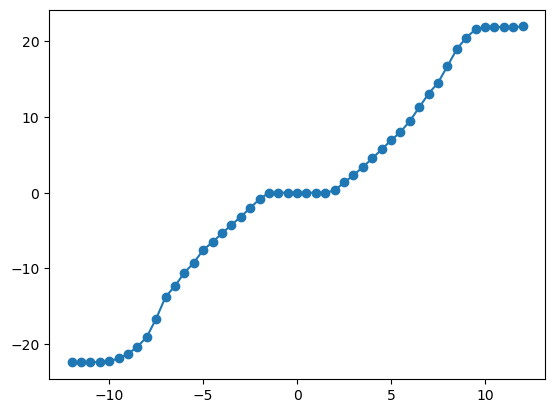

In [42]:
plt.plot(estacionarios[:,0], np.mean(estacionarios[:,2:], axis=1), '-o', label='meas')

sims = np.zeros((estacionarios.shape[0], 2))
for i, volt in enumerate(estacionarios[:,0]):
    t = np.linspace(0, 10, 100)
    ts, ys = ct.input_output_response(sys, t, volt)
    stationary = ys[-1]
    sims[i] = (volt, stationary)

plt.plot(sims[:,0], sims[:,1], '-o', label='sim')
plt.legend()
plt.title('Estacionario')
plt.xlabel('Input (V)')
plt.ylabel('Output (Hz)')

#### Pruebo PID

In [31]:
class PID_Clamp:
    def __init__(self, kp, ki, kd, dt, set_point, min_val, max_val):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.set_point = set_point
        self.max_val = max_val
        self.min_val = min_val
        
        self.action = 0
        a0 = self.kp + (self.ki * self.dt) + self.kd
        a1 = (-self.kp) - (2 * self.kd)
        a2 = self.kd
        self.a = np.array([a0, a1, a2])
        self.history = np.zeros(3)

    def __call__(self, state):
        self.history[2] = self.history[1]
        self.history[1] = self.history[0]
        self.history[0] = self.set_point - state # error

        self.action += np.dot(self.history, self.a)
        
        self.action = PID_Clamp.anti_windup(self.action, self.min_val, self.max_val)
        return self.action, self.history[0] # action, error
        
    @staticmethod
    def anti_windup( action, min_v, max_v):
        if action > max_v: return max_v
        elif action < min_v: return min_v
        return action

PID

In [40]:
kp, ki, kd = get_PID_params('PID')
kp, ki, kd = 16, 30, .3
dt = 0.0001
ti = 0
tf = 3
set_point = 6

t_arr = np.arange(ti, tf, dt)
y_arr = np.zeros(t_arr.shape[0])
actions_arr = np.zeros(t_arr.shape[0])
n = len(sys.pole())
x_prev = np.zeros(n)

pid = PID_Clamp(kp, ki, kd, dt, set_point, -12, 12)
for i, t in enumerate(t_arr):
    state = y_arr[i-1]
    action, error = pid(state)
    actions_arr[i] = action

    trd = ct.forced_response(sys, [t-dt, t], [actions_arr[i], actions_arr[i-1]], X0=x_prev) # times, outputs, states
    t_temp, y_temp, x_temp = trd.t, trd.y, trd.x
    y_arr[i] = np.squeeze(y_temp)[-1]
    x_prev = np.squeeze(x_temp)[-1]

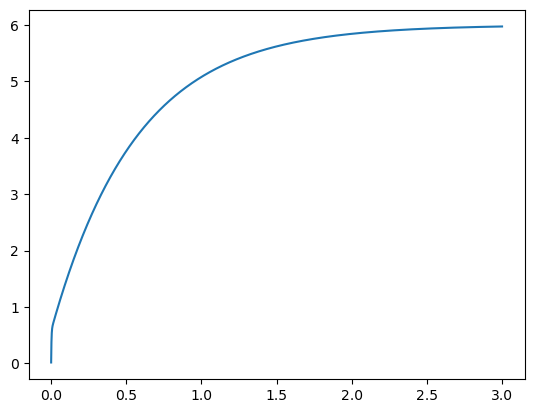

In [41]:
plt.plot(t_arr, y_arr, '-')